In [1]:
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import matplotlib
matplotlib.rcParams['axes.formatter.useoffset'] = False
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, Normalize
plt.style.use('ggplot')

# Convert warnings to exceptions
import warnings
warnings.simplefilter('error', UserWarning)

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')# 'svg')#, 'pdf')
%config InlineBackend.figure_format = 'retina'

## Utilities

In [3]:
def plot_vector(v, bins=None, *args, **kwargs):
    if bins is None:
        bins = range(len(v) + 1)
    plt.plot(bins, np.concatenate((v, [np.nan])), drawstyle='steps-post', *args, **kwargs)
    if bins is not None:
        plt.xlim(bins[0], bins[-1])

def plot_histo1d(xs, bins=None, weights=None, cut=None, normalize=False, **kwargs):
    assert bins is not None
    assert weights is not None
    if cut is not None:
        xs = xs[cut]
        weights = weights[cut]
    h = np.histogram(xs, bins=bins, weights=weights)
    ys = h[0]
    if normalize is True:
        ys = ys / ys.sum()
    elif normalize not in [False, None]:
        ys = ys / normalize
    plot_vector(ys, bins=h[1], **kwargs)
    return h

def plot_histo2d(xs, ys, bins=None, weights=None, cut=None, norm=None):
    assert bins is not None
    assert weights is not None
    if cut is not None:
        xs = xs[cut]
        ys = ys[cut]
        weights = weights[cut]
    h = np.histogram2d(xs, ys, bins=bins, weights=weights)
    pc = plt.pcolormesh(h[1], h[2], h[0].T, cmap='Oranges', norm=norm)
    plt.colorbar(pc)
    return h

from functools import reduce
def and_cuts(*args):
    return reduce(np.logical_and, args)

test_cut = np.array([True, False, True])
assert (and_cuts(test_cut) == test_cut).all()
assert (and_cuts(test_cut, test_cut) == test_cut).all()
assert not and_cuts(test_cut, np.logical_not(test_cut)).any()

def popcount64(n):
    if type(n) is int:
        n = np.uint64(n)
    n = (n & np.uint64(0x5555555555555555)) + ((n & np.uint64(0xAAAAAAAAAAAAAAAA)) >> np.uint64(1))
    n = (n & np.uint64(0x3333333333333333)) + ((n & np.uint64(0xCCCCCCCCCCCCCCCC)) >> np.uint64(2))
    n = (n & np.uint64(0x0F0F0F0F0F0F0F0F)) + ((n & np.uint64(0xF0F0F0F0F0F0F0F0)) >> np.uint64(4))
    n = (n & np.uint64(0x00FF00FF00FF00FF)) + ((n & np.uint64(0xFF00FF00FF00FF00)) >> np.uint64(8))
    n = (n & np.uint64(0x0000FFFF0000FFFF)) + ((n & np.uint64(0xFFFF0000FFFF0000)) >> np.uint64(16))
    n = (n & np.uint64(0x00000000FFFFFFFF)) + (n >> np.uint64(32))
    return n

assert popcount64(0) == 0
assert popcount64(1) == 1
assert popcount64(2) == 1
assert popcount64(3) == 2
for i in range(63):
    assert popcount64((1 << i) - 1) == i
for i in range(32):
    assert popcount64(0xDEADBEEF << i) == popcount64(0xDEADBEEF)
assert popcount64(0xFFFFFFFFFFFFFFFF) == 64

In [4]:
TPC_NUM_ROWS = 45
TPC_MASK = (1 << TPC_NUM_ROWS) - 1
TPC_OUTER_MASK = 0x1FFFFFFFE000
TPC_INNER_MASK = 0x1FFF
TPC_SHIFT = 8

assert TPC_MASK & TPC_OUTER_MASK == TPC_OUTER_MASK
assert TPC_MASK | TPC_OUTER_MASK == TPC_MASK
assert TPC_MASK & TPC_INNER_MASK == TPC_INNER_MASK
assert TPC_MASK | TPC_INNER_MASK == TPC_MASK
assert TPC_INNER_MASK & TPC_OUTER_MASK == 0
assert TPC_INNER_MASK | TPC_OUTER_MASK == TPC_MASK

bin_xsec = pd.Series({ # [mb]
    "pt2_3"   : 8.998960e+00,
    "pt3_4"   : 1.463983e+00,
    "pt4_5"   : 3.543083e-01,
    "pt5_7"   : 1.529195e-01,
    "pt7_9"   : 2.494312e-02,
    "pt9_11"  : 5.851208e-03,
    "pt11_15" : 2.305567e-03,
    "pt15_20" : 3.465733e-04,
    "pt20_25" : 4.623700e-05,
    "pt25_35" : 9.962600e-06,
    "pt35_-1" : 4.957917e-07,
})

## Theory

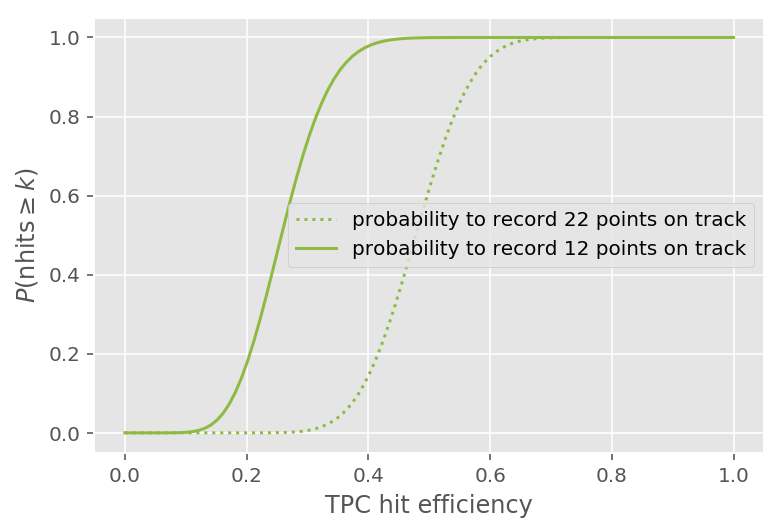

In [5]:
import scipy.stats

ps = np.linspace(0., 1., 100)
track_eff22 = []
track_eff12 = []

for p in ps:
    pp = scipy.stats.binom.pmf(range(TPC_NUM_ROWS+1), TPC_NUM_ROWS, p)
    track_eff22.append(pp[22:].sum() / pp.sum())
    track_eff12.append(pp[12:].sum() / pp.sum())
    
plt.plot(ps, track_eff22, label="probability to record 22 points on track", color='C5', ls=':')
plt.plot(ps, track_eff12, label="probability to record 12 points on track", color='C5', ls='-')

plt.xlabel("TPC hit efficiency")
plt.ylabel(r"$P(\mathrm{nhits} \geq k)$")
plt.legend()
plt.show()

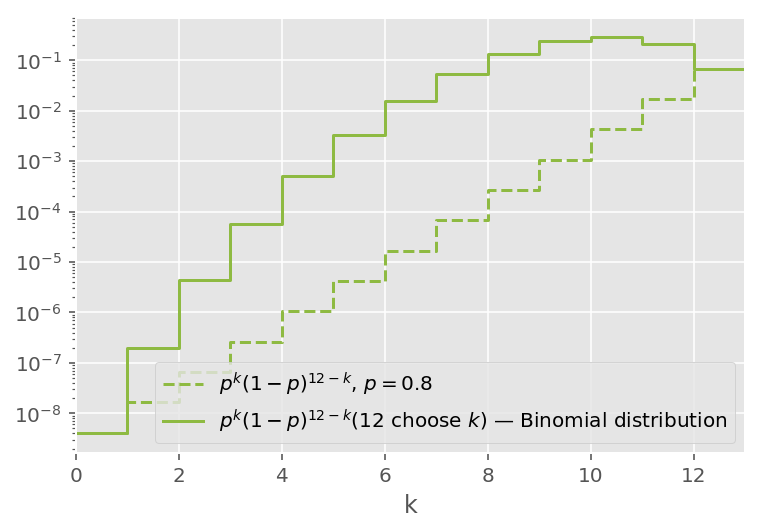

In [6]:
p = 0.8
N = 12
k = np.array(range(N+1))
xs = (p**(k)) * ((1-p)**(N-k))
plot_vector(xs, label=r"$p^{{k}} (1-p)^{{{N}-k}}$, $p = {p}$".format(N=N, p=p), color='C5', ls='--')
xs = scipy.stats.binom.pmf(range(N+1), N, p)
import scipy.special
assert np.allclose(
    xs,
    scipy.special.comb(N, k) * (p**(k)) * ((1-p)**(N-k))
)
plot_vector(xs,  label=r"$p^{{k}} (1-p)^{{{N}-k}}$({N} choose $k$) — Binomial distribution".format(N=N), color='C5')
plt.xlabel("k")
plt.yscale('log')
plt.legend()
plt.show()

## Data analysis

In [7]:
class DataSet:
    def __init__(self, filename, is_embed=False, title=None):
        table = pq.read_table(filename)
        self.ds = table.to_pandas()
        ds = self.ds
        self.is_embed = is_embed
        self.title = title

        ds['numPrimaryTracks'] = ds['primaryTrackPt'].map(len)
        if is_embed:
            tracks_per_bin = ds.groupby('eventPtBin')['numPrimaryTracks'].sum()
            bin_weight = bin_xsec / tracks_per_bin
            
            ds['eventWeight'] = bin_weight[ds['eventPtBin']].reset_index(drop=True)
            ds['primaryTrackWeight'] = ds.apply(lambda row: [row['eventWeight']] * row['numPrimaryTracks'], axis=1)
        else:
            ds['eventWeight'] = 1
        ds['primaryTrackWeight'] = ds.apply(lambda row: [row['eventWeight']] * row['numPrimaryTracks'], axis=1)
        
        # These arrays are inclusive in tracks (not events)
        self.w = np.concatenate(ds['primaryTrackWeight'].values)
        self.tm = np.concatenate(ds['primaryTrackTopologyMap'].values)
        self.tpc_tm = (self.tm >> np.uint64(TPC_SHIFT)) & np.uint64(TPC_MASK)
        self.nhits = np.concatenate(ds['primaryTrackNHits'].values)
        assert np.all(self.nhits <= TPC_NUM_ROWS)
        assert np.all(popcount64(self.tpc_tm) == self.nhits)
        self.nph = np.concatenate(ds['primaryTrackNHitsPoss'].values)
        self.pt = np.abs(np.concatenate(ds['primaryTrackPt'].values))
        self.phi = np.concatenate(ds['primaryTrackPhi'].values)
        self.eta = np.concatenate(ds['primaryTrackEta'].values)
        self.dEdx = np.concatenate(ds['primaryTrackdEdx'].values)
        self.chi2 = np.concatenate(ds['primaryTrackChi2'].values)
        self.vid = np.concatenate(ds['primaryTrackVertexId'].values)
        self.vrank = np.concatenate(ds['primaryTrackVertexRank'].values)
        self.vz = np.concatenate(ds['primaryTrackVertexZ'].values)
        self.charge = np.sign(np.concatenate(ds['primaryTrackPt'].values))
        self.id_truth = np.concatenate(ds['primaryTrackIdTruth'].values)
        self.qa_truth = np.concatenate(ds['primaryTrackQaTruth'].values)
        
        self.phi_cut = np.logical_or(self.phi > 0.5, self.phi < -2.1)
        self.nph46_cut = self.nph == 46
        self.vertex_cut = and_cuts(self.vid==0, self.vrank>0, np.abs(self.vz)<60)
    
    @property
    def erase_dict(self):
        return dict(map(lambda k: (k, None), self.__dict__.keys()))

datasets = [
    DataSet("/tmp/output.parquet", title="13059025 data"),
    DataSet("13059025_emb/output.parquet", is_embed=True, title="13059025 embedding"),
]

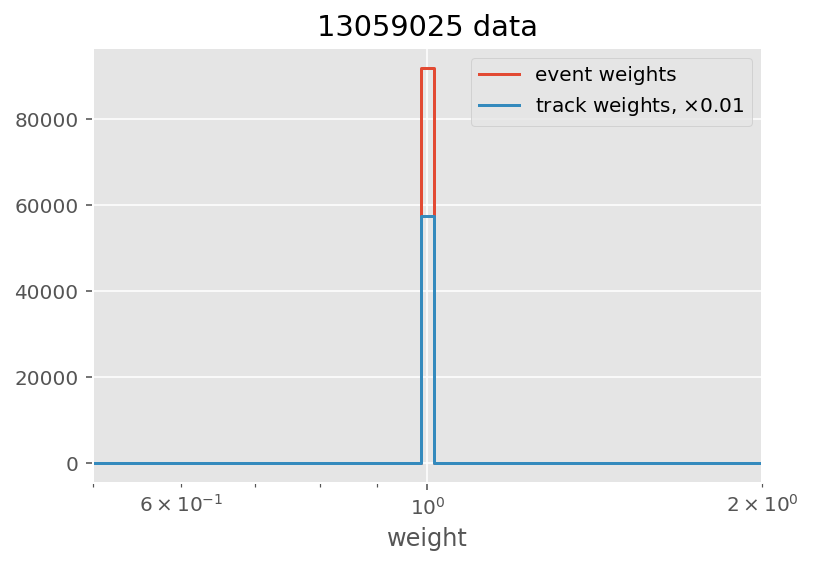

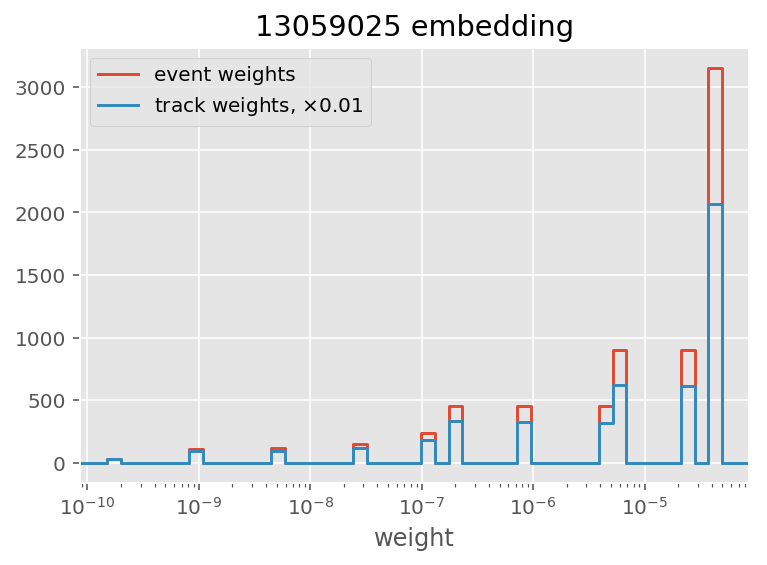

In [8]:
for xds in datasets:
    locals().update(xds.__dict__)

    h = np.histogram(ds['eventWeight'], bins=np.geomspace(ds['eventWeight'].min()/2, ds['eventWeight'].max()*2, 50))
    plot_vector(h[0], bins=h[1], label="event weights")

    h = np.histogram(w, bins=h[1])
    plot_vector(h[0] * 0.01, bins=h[1], label=r"track weights, $\times 0.01$")
    
    """
    (_, bins) = plot_histo1d(
        ds['eventWeight'],
        bins=np.geomspace(ds['eventWeight'].min()/2, ds['eventWeight'].max()*2, 50),
        weights=np.ones_like(ds['eventWeight']),
        label="event weights",
        ls=":"
        )

    plot_histo1d(
        w,
        bins=bins,
        weights=np.ones_like(w),
        label="event weights",
        ls=":"
        )
    """

    plt.xscale('log')
    plt.xlabel("weight")
    plt.legend()
    plt.title(title)
    plt.show()

    locals().update(xds.erase_dict)

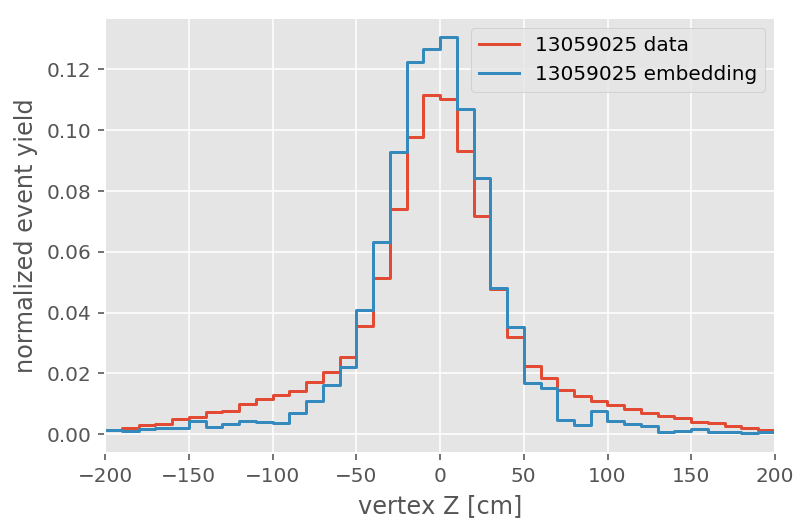

In [9]:
bins = 40
for xds in datasets:
    locals().update(xds.__dict__)

    (_, bins) = plot_histo1d(
        ds['primaryTrackVertexZ'].map(lambda xs: xs[0] if len(xs) else np.nan),
        bins=bins,
        weights=ds['eventWeight'],
        cut=ds['numPrimaryTracks'] != 0, # XXX weird
        normalize=True,
        label=title,
        )
    
    locals().update(xds.erase_dict)

plt.xlabel("vertex Z [cm]")
plt.ylabel("normalized event yield")
plt.legend()
plt.show()

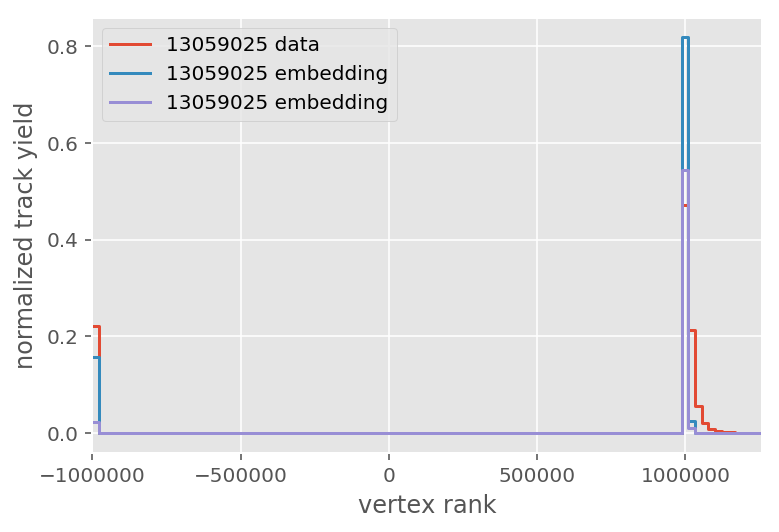

In [10]:
bins = 100
for xds in datasets:
    locals().update(xds.__dict__)

    (ys, bins) = plot_histo1d(
        vrank,
        bins=bins,
        weights=w,
        cut=vid==0,
        normalize=True,
        label=title,
        )
    
    if is_embed:
        (_, bins) = plot_histo1d(
            vrank,
            bins=bins,
            weights=w,
            cut=and_cuts(vid==0, id_truth!=0),
            normalize=ys.sum(),
            label=title,
            )
    
    locals().update(xds.erase_dict)
    
plt.xlabel("vertex rank")
plt.ylabel("normalized track yield")
plt.legend()
plt.show()

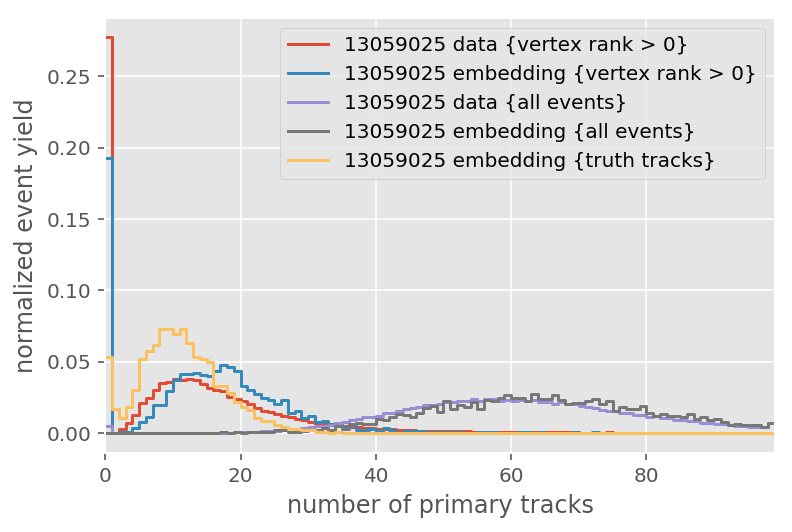

In [11]:
bins = range(100)
for xds in datasets:
    locals().update(xds.__dict__)
    
    def numPosRankTracks(row):
        """
        Number of non pile-up vertices
        """
        rank = row['primaryTrackVertexRank']
        return (rank > 0).sum()
    numTracks = ds.apply(numPosRankTracks, axis=1)

    (_, bins) = plot_histo1d(
        numTracks,
        bins=bins,
        weights=ds['eventWeight'],
        normalize=True,
        label="{} track vertex rank > 0".format(title),
        )
    
    locals().update(xds.erase_dict)
    
for xds in datasets:
    locals().update(xds.__dict__)
    
    (_, bins) = plot_histo1d(
        ds['numPrimaryTracks'],
        bins=bins,
        weights=ds['eventWeight'],
        normalize=True,
        label="{}".format(title),
        )

    if is_embed:
        def numTruthTracks(ids_truth):
            return len(list(filter(lambda id_truth: id_truth != 0, ids_truth)))

        numTruthTracks = ds['primaryTrackIdTruth'].map(numTruthTracks)
        (_, bins) = plot_histo1d(
            numTruthTracks,
            bins=bins,
            weights=ds['eventWeight'],
            normalize=True,
            label="{} {{truth tracks}}".format(title),
            )

    locals().update(xds.erase_dict)

plt.xlabel("number of primary tracks")
plt.ylabel("normalized event yield")
plt.legend()
plt.show()

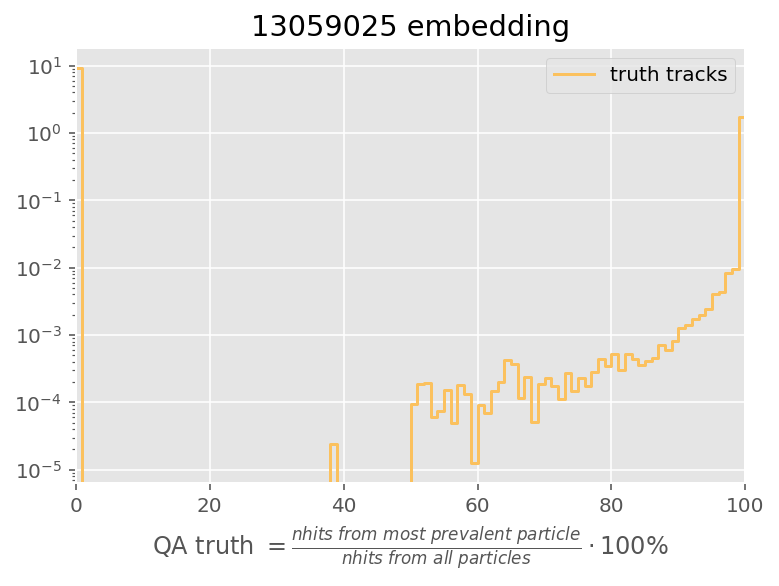

In [12]:
bins = 100
for xds in datasets:
    if not xds.is_embed: continue

    locals().update(xds.__dict__)

    (_, bins) = plot_histo1d(
        qa_truth,
        bins=bins,
        weights=w,
        label="truth tracks",
        color='C4',
        )
    plt.yscale('log')
    plt.xlabel(r"QA truth $=\frac{nhits\ from\ most\ prevalent\ particle}{nhits\ from\ all\ particles} \cdot 100\%$")
    plt.title(title)
    plt.legend()
    plt.show()

    locals().update(xds.erase_dict)

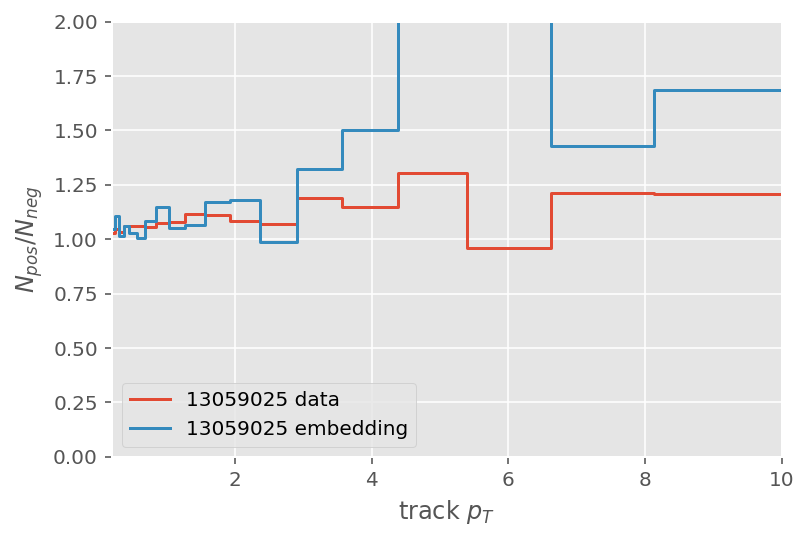

In [26]:
bins = np.geomspace(0.2, 10, 20)

for xds in datasets:
    locals().update(xds.__dict__)

    cut = and_cuts(vertex_cut, pt<10, charge>0)
    h_plus = np.histogram(pt[cut], bins=bins, weights=w[cut])
    bins = h_plus[1]
    cut = and_cuts(vertex_cut, pt<10, charge<0) 
    h_minus = np.histogram(pt[cut], bins=bins, weights=w[cut])
    ratio = h_plus[0] / h_minus[0]
    plot_vector(ratio, bins=bins, label=title)

    locals().update(xds.erase_dict)
    
plt.xlabel(r"track $p_T$")
plt.ylabel(r"$N_{pos} / N_{neg}$")
plt.ylim(0., 2.)
plt.legend()
plt.show()

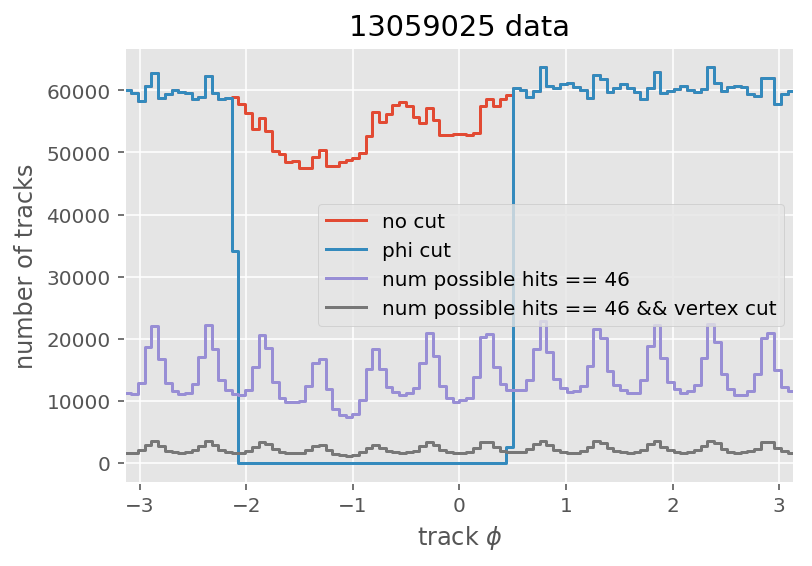

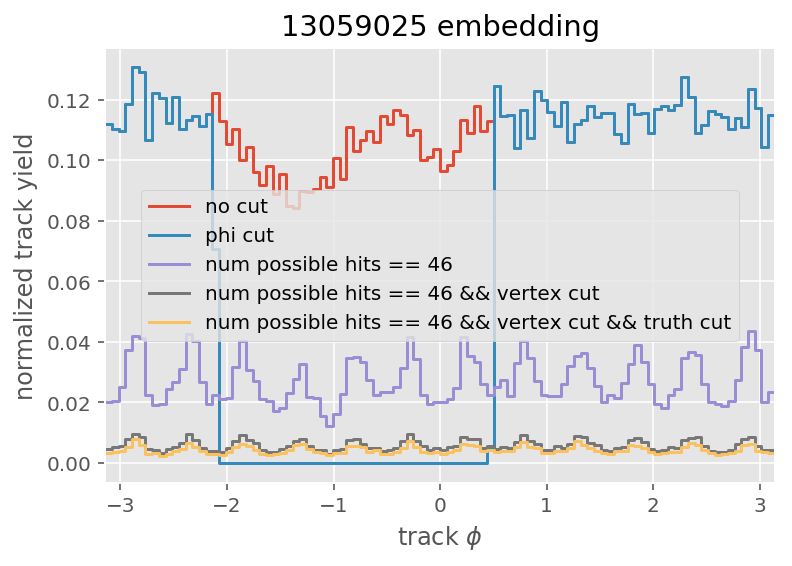

In [14]:
for xds in datasets:
    locals().update(xds.__dict__)

    bins = 100
    (_, bins) = plot_histo1d(
        phi,
        bins=bins,
        weights=w,
        label="no cut",
        )
    (_, bins) = plot_histo1d(
        phi,
        bins=bins,
        weights=w,
        cut=phi_cut,
        label="phi cut",
        )
    (_, bins) = plot_histo1d(
        phi,
        bins=bins,
        weights=w,
        cut=nph46_cut,
        label="num possible hits == 46",
        )
    (_, bins) = plot_histo1d(
        phi,
        bins=bins,
        weights=w,
        cut=and_cuts(nph46_cut, vertex_cut),
        label="num possible hits == 46 && vertex cut",
        )
    if is_embed:
        (_, bins) = plot_histo1d(
            phi,
            bins=bins,
            weights=w,
            cut=and_cuts(nph46_cut, vertex_cut, id_truth!=0),
            label="num possible hits == 46 && vertex cut && truth cut",
            )
    plt.legend()
    plt.xlabel("track $\phi$")
    plt.ylabel("normalized track yield" if is_embed else "number of tracks")
    plt.title(title)
    plt.show()

    locals().update(xds.erase_dict)

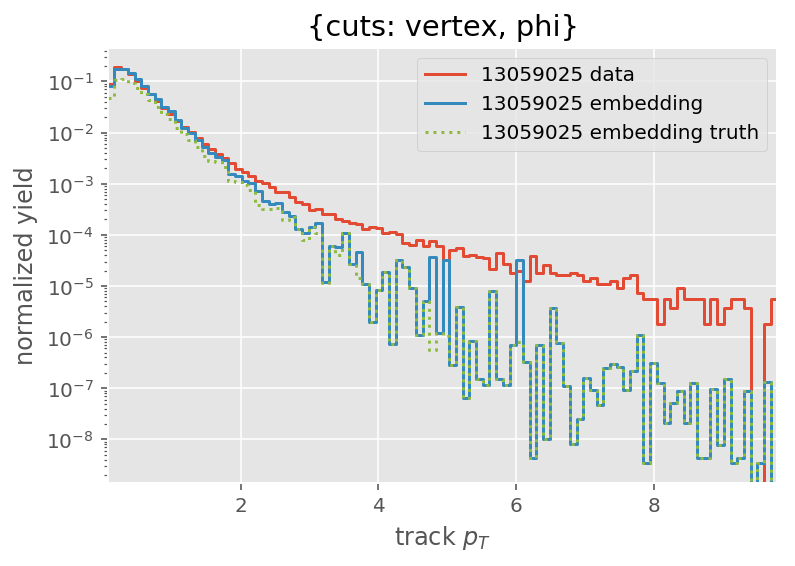

In [15]:
bins = 100
for xds in datasets:
    locals().update(xds.__dict__)

    (ys, bins) = plot_histo1d(
        pt,
        bins=bins,
        weights=w,
        cut=and_cuts(vertex_cut, phi_cut, pt<10),
        normalize=True,
        label=title,
        )
    
    if is_embed:
        (_, bins) = plot_histo1d(
            pt,
            bins=bins,
            weights=w,
            cut=and_cuts(vertex_cut, phi_cut, pt<10, id_truth!=0),
            normalize=ys.sum(),
            label="{} truth".format(title),
            ls=':',
            color='C5',
            )

    locals().update(xds.erase_dict)
    
plt.yscale('log')
plt.xlabel(r"track $p_T$")
plt.ylabel("normalized yield")
plt.title("{cuts: vertex, phi}")
plt.legend()
plt.show()

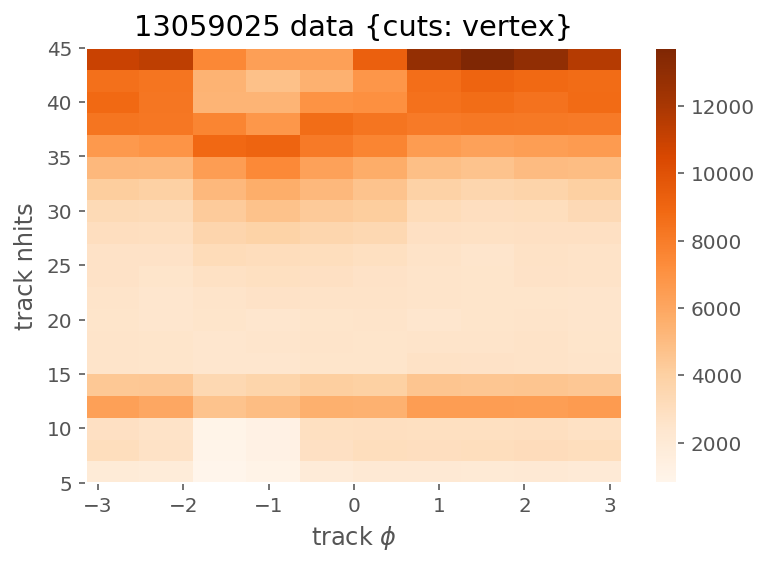

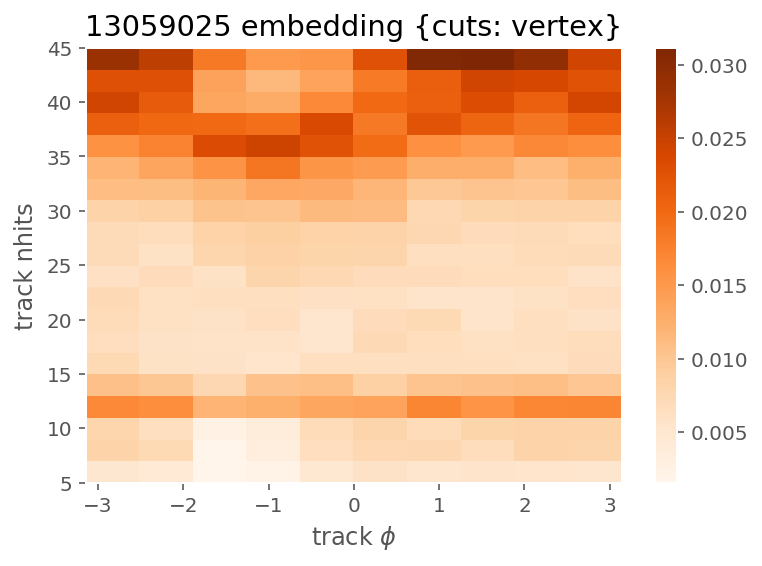

In [16]:
for xds in datasets:
    locals().update(xds.__dict__)

    plot_histo2d(
        phi, nhits,
        bins=(10, 20),
        weights=w,
        cut=vertex_cut,
        )
    plt.xlabel(r"track $\phi$")
    plt.ylabel(r"track nhits")
    plt.title("{} {{cuts: vertex}}".format(title))
    plt.show()
    
    locals().update(xds.erase_dict)

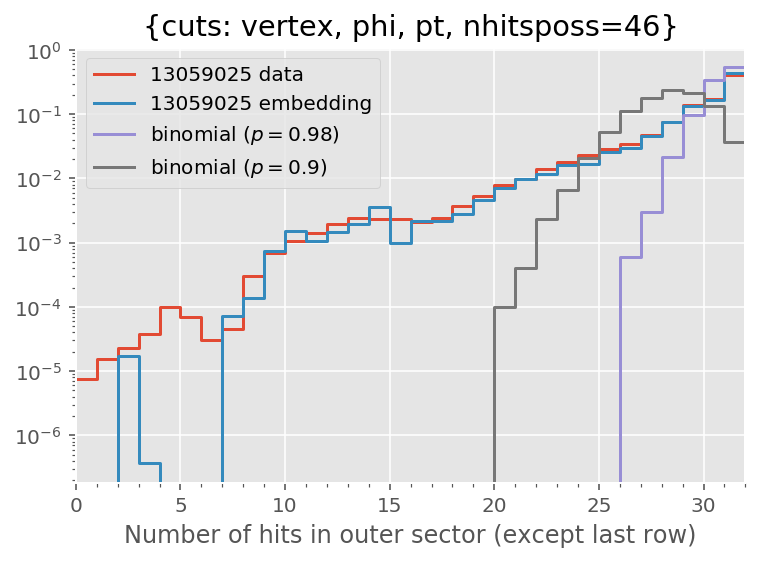

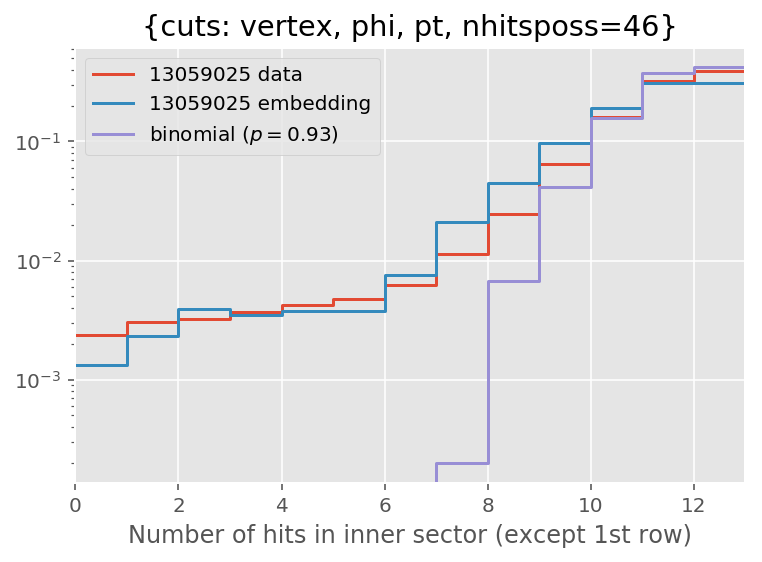

In [17]:
xxx_TPC_OUTER_MASK = 0xFFFFFFFE000
xxx_TPC_NUM_OUTER_ROWS = int(popcount64(xxx_TPC_OUTER_MASK))
xxx_TPC_INNER_MASK = 0x1FFE
xxx_TPC_NUM_INNER_ROWS = int(popcount64(xxx_TPC_INNER_MASK))

for xds in datasets:
    locals().update(xds.__dict__)

    nhits_outer = popcount64(tpc_tm & xxx_TPC_OUTER_MASK)
    plot_histo1d(
        nhits_outer,
        bins=range(xxx_TPC_NUM_OUTER_ROWS+2),
        weights=w,
        cut=and_cuts(vertex_cut, phi_cut, pt > 0.2, nph46_cut),
        normalize=True,
        label=title,
        )
    
    locals().update(xds.erase_dict)

p = 0.98
N = 10000
_simu_nhits = np.random.binomial(xxx_TPC_NUM_OUTER_ROWS, p, N)
h = np.histogram(_simu_nhits, bins=range(xxx_TPC_NUM_OUTER_ROWS+2))
plot_vector(h[0] / N, label=r"binomial ($p = {}$)".format(p))

p = 0.90
N = 10000
_simu_nhits = np.random.binomial(xxx_TPC_NUM_OUTER_ROWS, p, N)
h = np.histogram(_simu_nhits, bins=range(xxx_TPC_NUM_OUTER_ROWS+2))
plot_vector(h[0] / N, label=r"binomial ($p = {}$)".format(p))

plt.xlabel("Number of hits in outer sector (except last row)")
plt.legend()
plt.yscale('log')
plt.minorticks_on()
plt.title("{cuts: vertex, phi, pt, nhitsposs=46}")
plt.show()

for xds in datasets:
    locals().update(xds.__dict__)
    
    nhits_inner = popcount64(tpc_tm & xxx_TPC_INNER_MASK)
    plot_histo1d(
        nhits_inner,
        bins=range(xxx_TPC_NUM_INNER_ROWS+2),
        weights=w,
        cut=and_cuts(vertex_cut, phi_cut, pt > 0.2, nph46_cut),
        normalize=True,
        label=title,
        )

p = 0.93
N = 10000
_simu_nhits = np.random.binomial(xxx_TPC_NUM_INNER_ROWS, p, N)
h = np.histogram(_simu_nhits, bins=range(xxx_TPC_NUM_INNER_ROWS+2))
plot_vector(h[0] / N, label="binomial ($p = {}$)".format(p))

plt.xlabel("Number of hits in inner sector (except 1st row)")
plt.legend()
plt.yscale('log')
#plt.minorticks_on()
plt.title("{cuts: vertex, phi, pt, nhitsposs=46}")
plt.show()

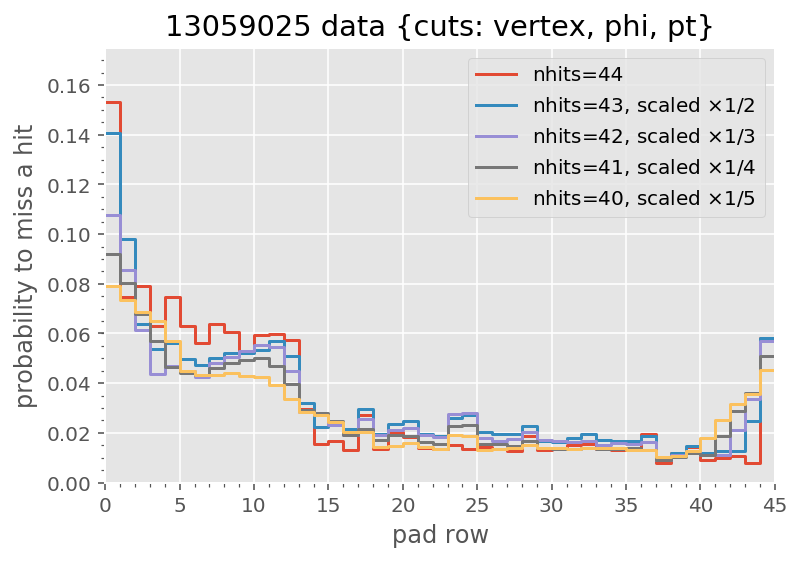

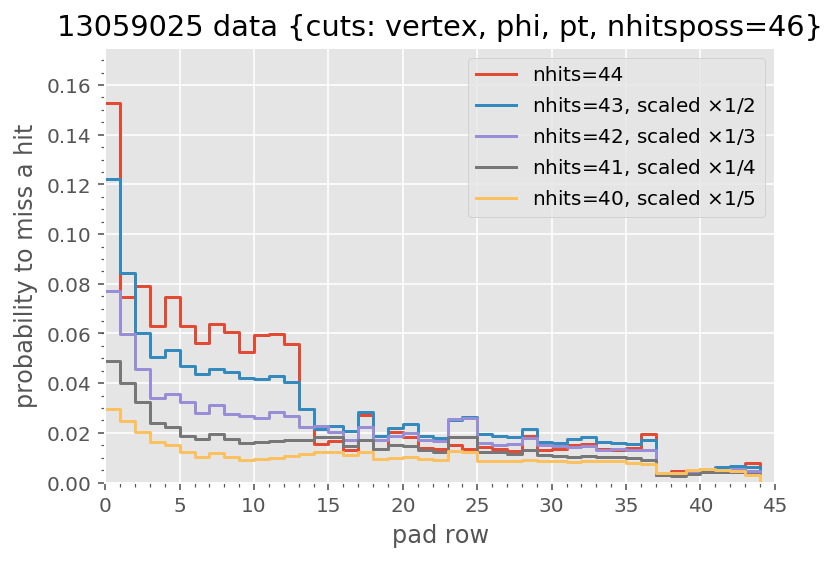

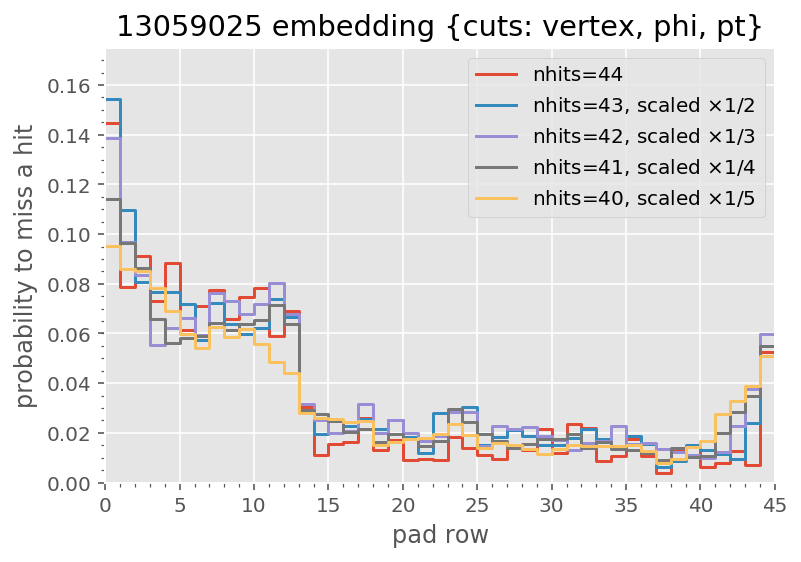

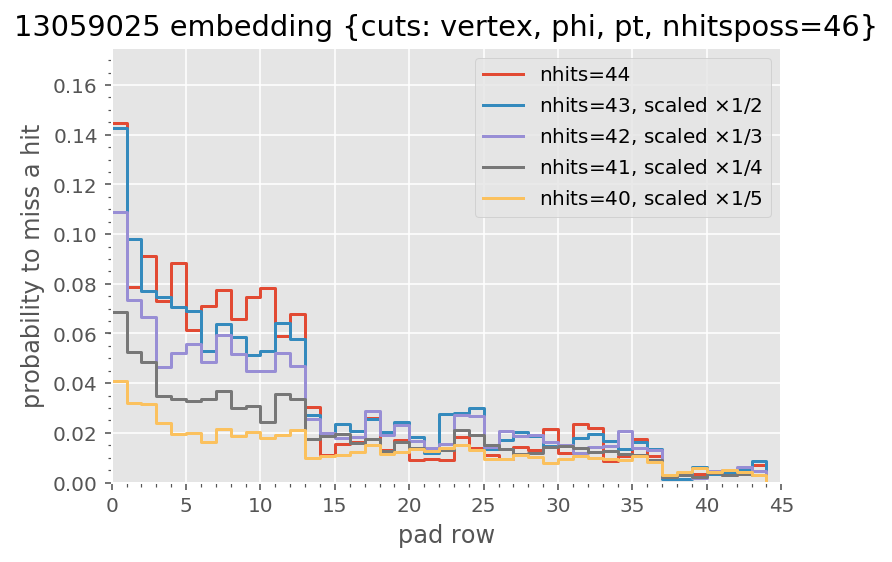

In [18]:
for xds in datasets:
    locals().update(xds.__dict__)
    
    assert np.all(nhits <= TPC_NUM_ROWS)
    nhits45_cut = nhits == 45
    assert np.all(tpc_tm[nhits45_cut] == TPC_MASK)

    def show_for(cut_common, cut_hits, label, comb_factor):
        cut_miss = and_cuts(cut_hits, cut_common)
        cut_norm = and_cuts(nhits == 45, cut_common)
        gap_counts = np.zeros((TPC_NUM_ROWS))
        for i in range(TPC_NUM_ROWS):
            mask = np.uint64(1 << i)
            gap_counts[i] = w[cut_miss][(tpc_tm[cut_miss] & mask) == 0].sum()
        plot_vector(gap_counts / w[cut_norm].sum() / comb_factor, label=label)

    cut_common = and_cuts(vertex_cut, phi_cut, pt > 0.2)
    show_for(cut_common, nhits==44, "nhits=44", 1)
    show_for(cut_common, nhits==43, r"nhits=43, scaled $\times 1/2$", 2)
    show_for(cut_common, nhits==42, r"nhits=42, scaled $\times 1/3$", 3)
    show_for(cut_common, nhits==41, r"nhits=41, scaled $\times 1/4$", 4)
    show_for(cut_common, nhits==40, r"nhits=40, scaled $\times 1/5$", 5)

    plt.xlabel("pad row")
    plt.ylabel("probability to miss a hit")
    plt.legend()
    plt.ylim(0., 0.175)
    plt.title(title)
    plt.minorticks_on()
    plt.title(title + " {cuts: vertex, phi, pt}")
    plt.show()
    
    cut_common = and_cuts(vertex_cut, phi_cut, pt > 0.2, nph46_cut)
    show_for(cut_common, nhits==44, "nhits=44", 1)
    show_for(cut_common, nhits==43, r"nhits=43, scaled $\times 1/2$", 2)
    show_for(cut_common, nhits==42, r"nhits=42, scaled $\times 1/3$", 3)
    show_for(cut_common, nhits==41, r"nhits=41, scaled $\times 1/4$", 4)
    show_for(cut_common, nhits==40, r"nhits=40, scaled $\times 1/5$", 5)

    plt.xlabel("pad row")
    plt.ylabel("probability to miss a hit")
    plt.legend()
    plt.ylim(0., 0.175)
    plt.title(title)
    plt.minorticks_on()
    plt.title(title + " {cuts: vertex, phi, pt, nhitsposs=46}")
    plt.show()
    
    locals().update(xds.erase_dict)

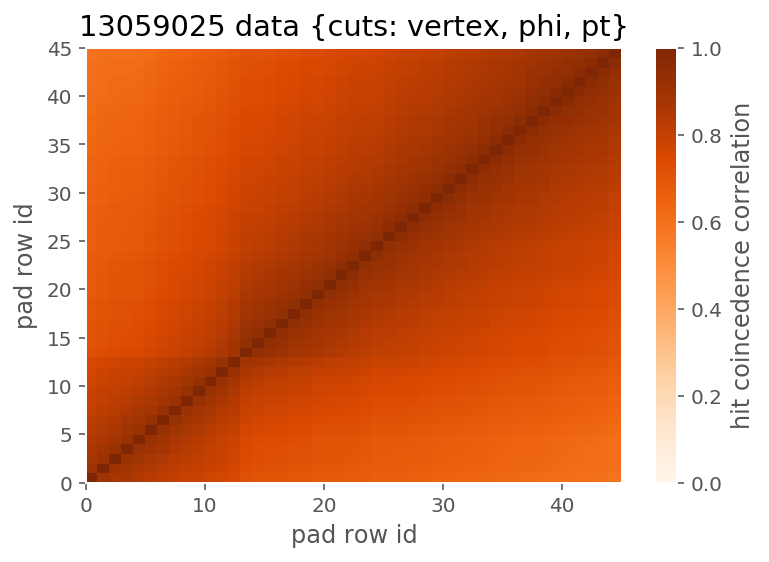

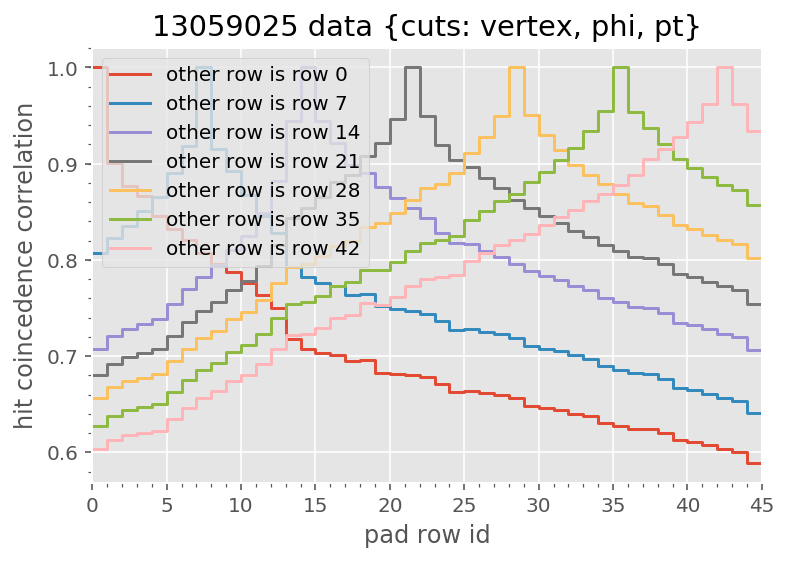

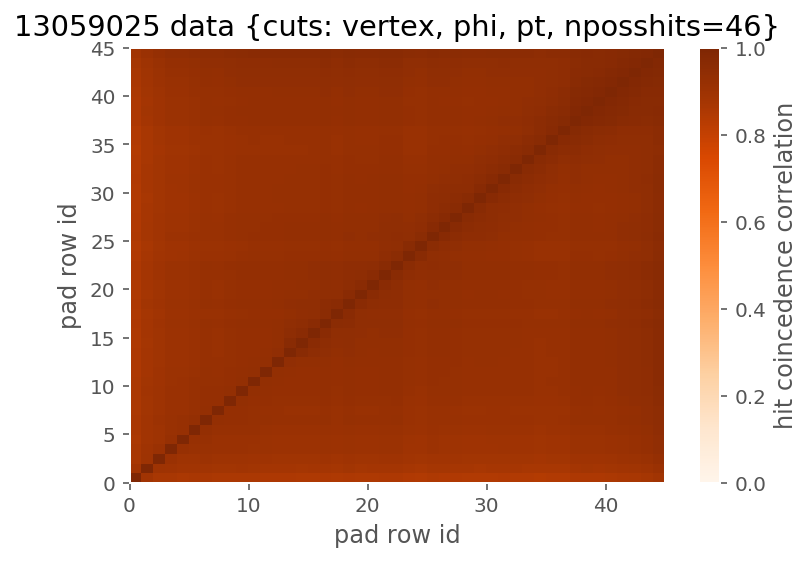

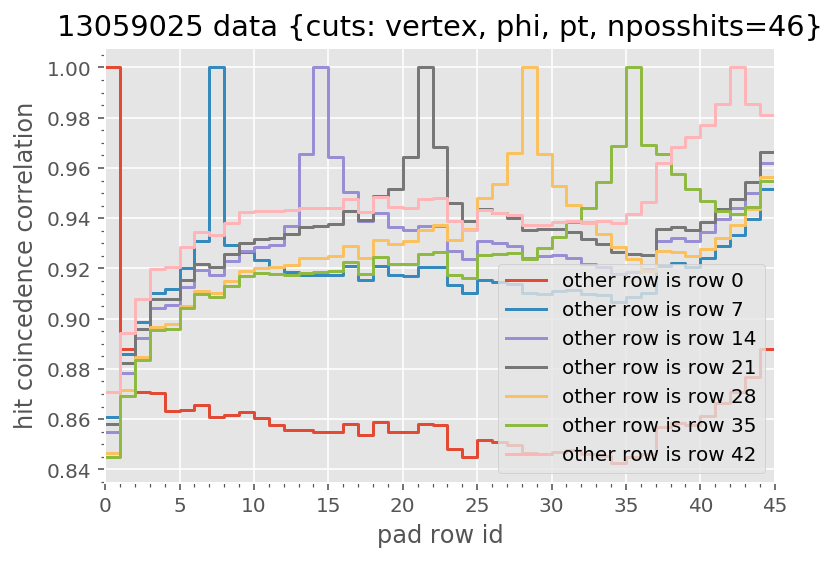

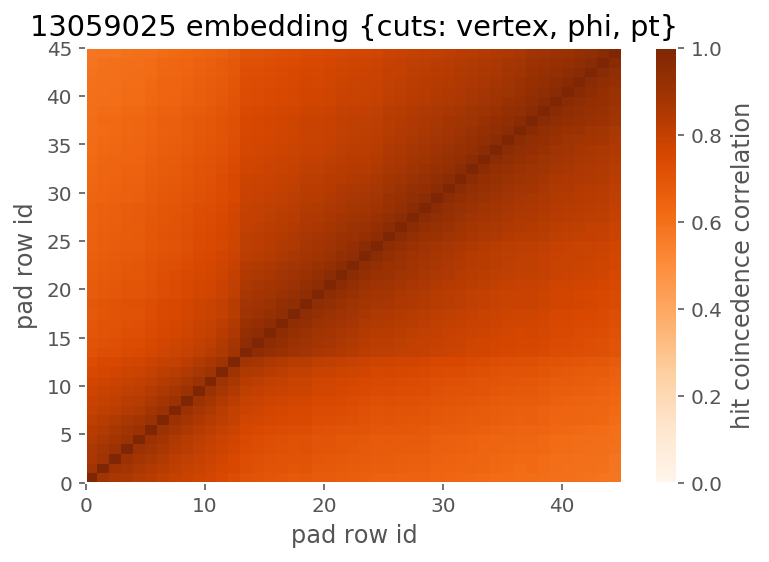

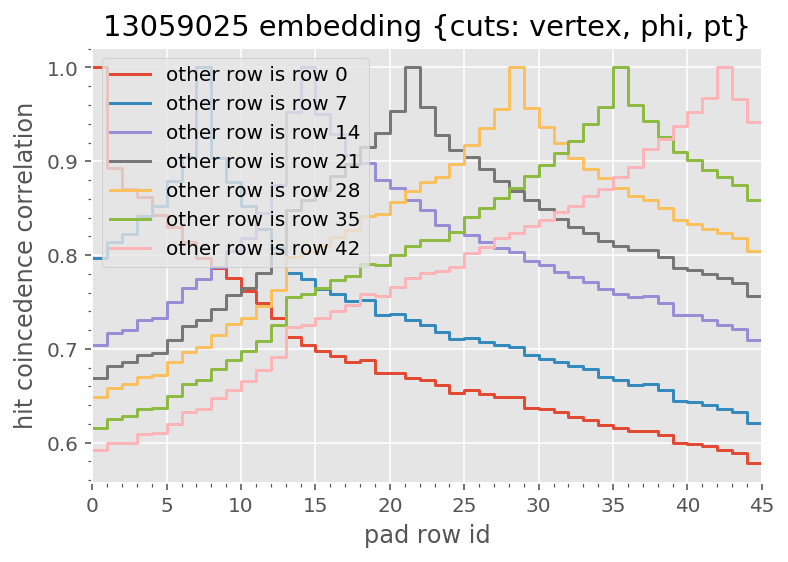

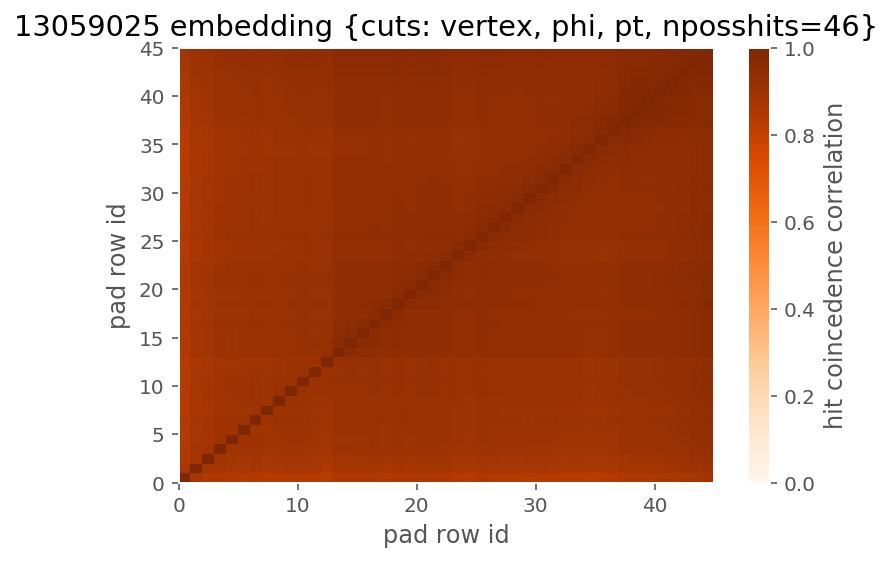

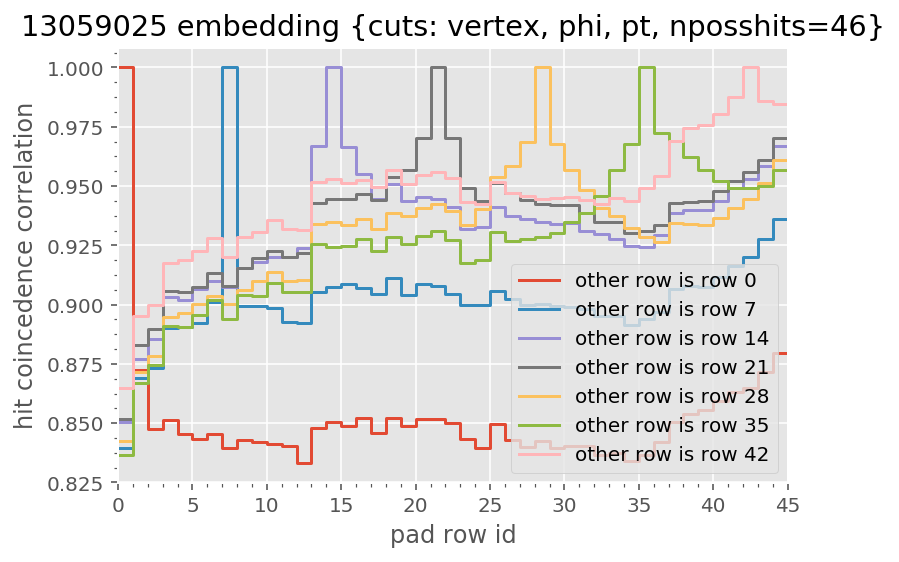

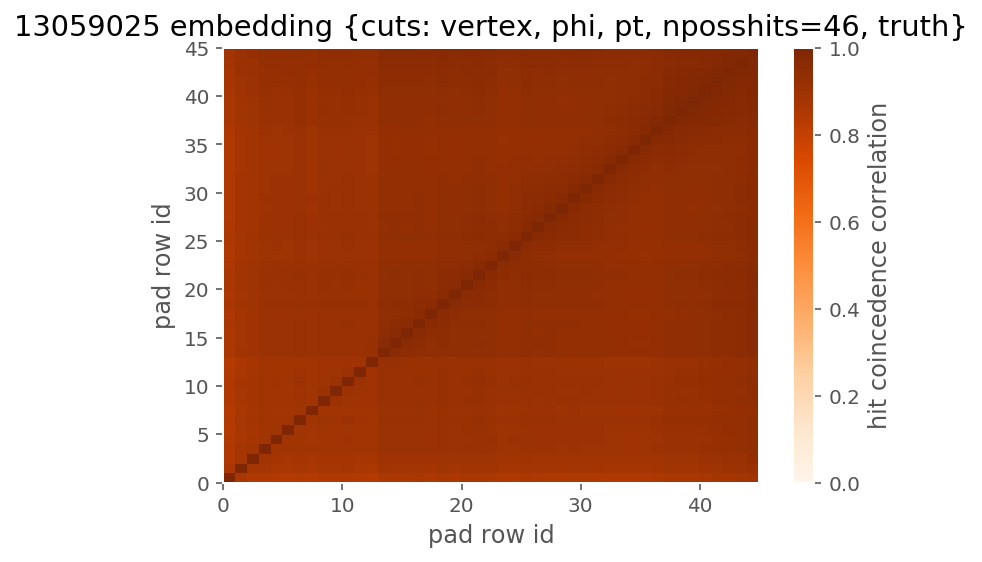

In [19]:
def corr_mat(tpc_tm, weight, cut):
    corr = np.zeros((TPC_NUM_ROWS, TPC_NUM_ROWS))
    weight=weight[cut]
    for i in range(TPC_NUM_ROWS):
        for j in range(i+1):
            comask = np.uint64((1 << i) | (1 << j))
            corr[i, j] = weight[(tpc_tm[cut] & comask) == comask].sum()
            corr[j, i] = corr[i, j]
    D = np.diag(1/np.sqrt(np.diag(corr)))
    return D.dot(corr).dot(D)

for xds in datasets:
    locals().update(xds.__dict__)

    cut = and_cuts(vertex_cut, phi_cut, pt>0.2)
    corr = corr_mat(tpc_tm, w, cut)
    pc = plt.pcolormesh(range(TPC_NUM_ROWS+1), range(TPC_NUM_ROWS+1), corr, norm=Normalize(0., 1.), cmap='Oranges')
    plt.colorbar(pc).set_label("hit coincedence correlation")
    plt.xlabel("pad row id"); plt.ylabel("pad row id")
    plt.title(title + " {cuts: vertex, phi, pt}")
    plt.show()
    for i in range(0, TPC_NUM_ROWS, 7):
        plot_vector(corr[i,:], label="other row is row {}".format(i))
    plt.xlabel("pad row id")
    plt.ylabel("hit coincedence correlation")
    plt.title(title + " {cuts: vertex, phi, pt}")
    plt.legend()
    plt.minorticks_on()
    plt.show()
    cut = and_cuts(vertex_cut, phi_cut, pt>0.2, nph46_cut)
    corr46 = corr_mat(tpc_tm, w, cut)
    pc = plt.pcolormesh(range(TPC_NUM_ROWS+1), range(TPC_NUM_ROWS+1), corr46, norm=Normalize(0., 1.), cmap='Oranges')
    plt.colorbar(pc).set_label("hit coincedence correlation")
    plt.xlabel("pad row id"); plt.ylabel("pad row id")
    plt.title(title + " {cuts: vertex, phi, pt, nposshits=46}")
    plt.show()
    for i in range(0, TPC_NUM_ROWS, 7):
        plot_vector(corr46[i,:], label="other row is row {}".format(i))
    plt.xlabel("pad row id")
    plt.ylabel("hit coincedence correlation")
    plt.title(title + " {cuts: vertex, phi, pt, nposshits=46}")
    plt.legend()
    plt.minorticks_on()
    plt.show()
    if is_embed:
        cut = and_cuts(vertex_cut, phi_cut, pt>0.2, nph46_cut, id_truth!=0)
        corr_truth = corr_mat(tpc_tm, w, cut)
        pc = plt.pcolormesh(range(TPC_NUM_ROWS+1), range(TPC_NUM_ROWS+1), corr_truth, norm=Normalize(0., 1.), cmap='Oranges')
        plt.colorbar(pc).set_label("hit coincedence correlation")
        plt.xlabel("pad row id"); plt.ylabel("pad row id")
        plt.title(title + " {cuts: vertex, phi, pt, nposshits=46, truth}")
        plt.show()

    locals().update(xds.erase_dict)

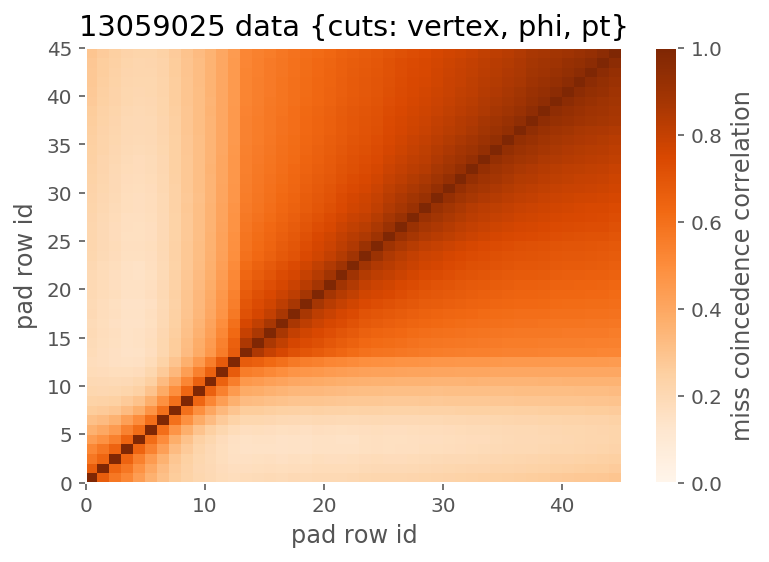

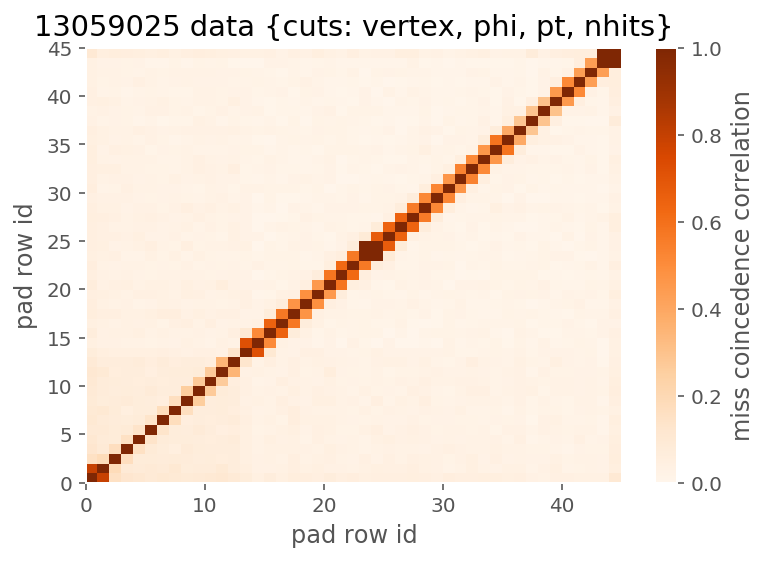

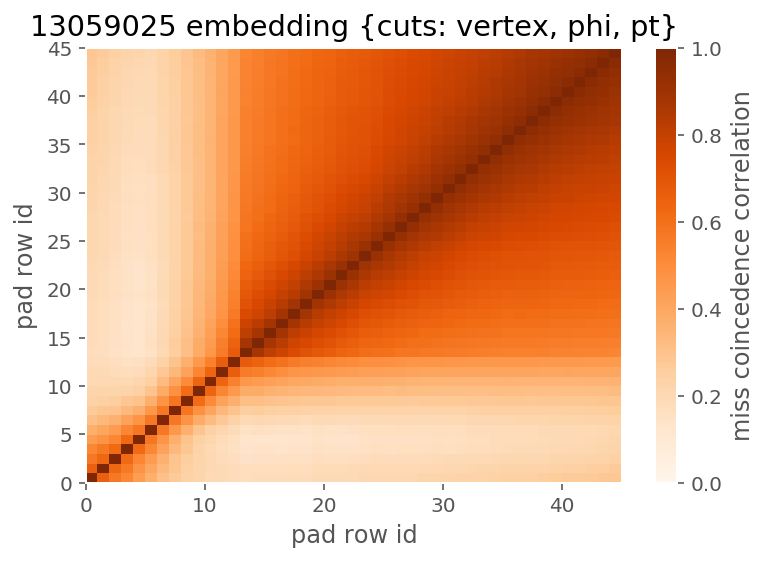

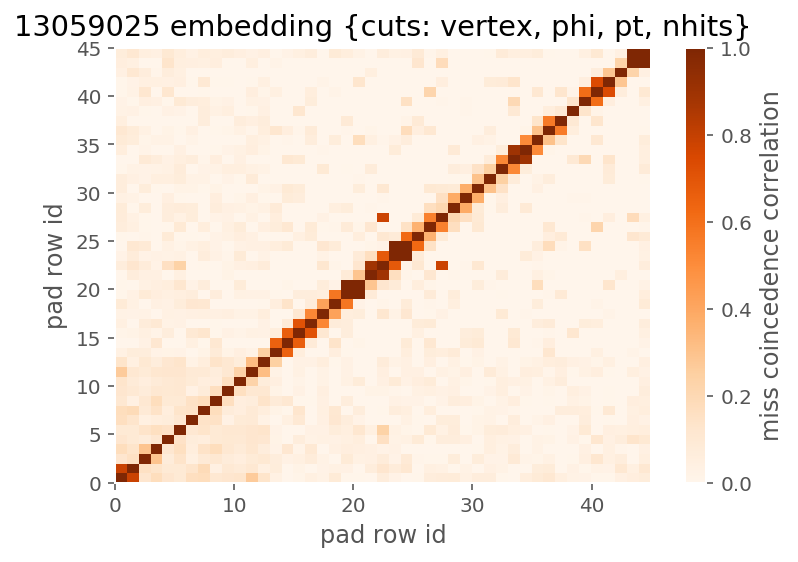

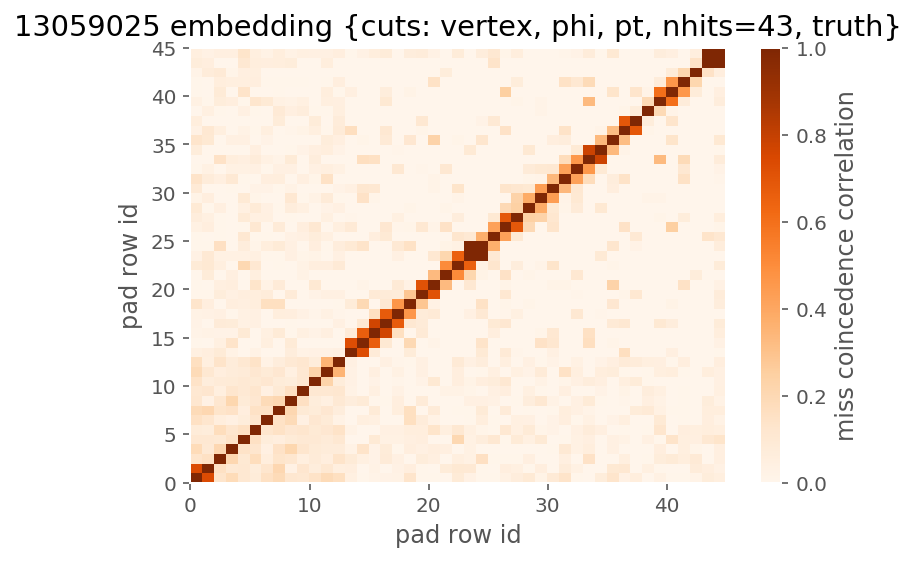

In [20]:
def corr_gap_mat(tpc_tm, nhits, weight, cut, nhits43=False):
    corr = np.zeros((TPC_NUM_ROWS, TPC_NUM_ROWS))
    tpc_tm = tpc_tm[cut]
    nhits = nhits[cut]
    weight = weight[cut]
    for i in range(TPC_NUM_ROWS):
        for j in range(i + 1):
            if nhits43:
                if i == j:
                    eff_tpc_tm = tpc_tm[nhits == 44]
                    eff_weight = weight[nhits == 44]
                else:
                    eff_tpc_tm = tpc_tm[nhits == 43]
                    eff_weight = weight[nhits == 43]
            else:
                eff_tpc_tm = tpc_tm
                eff_weight = weight
            comask = np.uint64((1 << i) | (1 << j))
            corr[i, j] = eff_weight[(eff_tpc_tm & comask) == 0].sum()
            corr[j, i] = corr[i, j]
    D = np.diag(1 / np.sqrt(np.diag(corr)))
    return D.dot(corr).dot(D)

for xds in datasets:
    locals().update(xds.__dict__)

    cut = and_cuts(vertex_cut, phi_cut, pt>0.2)
    corr_gap = corr_gap_mat(tpc_tm, nhits, w, cut, nhits43=False)
    pc = plt.pcolormesh(range(TPC_NUM_ROWS+1), range(TPC_NUM_ROWS+1), corr_gap, norm=Normalize(0., 1.), cmap='Oranges')
    plt.colorbar(pc).set_label("miss coincedence correlation")
    plt.xlabel("pad row id"); plt.ylabel("pad row id")
    plt.title(title + " {cuts: vertex, phi, pt}")
    plt.show()
    corr_gap_nhits43 = corr_gap_mat(tpc_tm, nhits, w, cut, nhits43=True)
    pc = plt.pcolormesh(range(TPC_NUM_ROWS+1), range(TPC_NUM_ROWS+1), corr_gap_nhits43, norm=Normalize(0., 1.), cmap='Oranges')
    plt.colorbar(pc).set_label("miss coincedence correlation")
    plt.xlabel("pad row id"); plt.ylabel("pad row id")
    plt.title(title + " {cuts: vertex, phi, pt, nhits}")
    plt.show()

    if is_embed:
        cut = and_cuts(cut, id_truth!=0)
        corr_gap_truth = corr_gap_mat(tpc_tm, nhits, w, cut, nhits43=True)
        pc = plt.pcolormesh(range(TPC_NUM_ROWS+1), range(TPC_NUM_ROWS+1), corr_gap_truth, norm=Normalize(0., 1.), cmap='Oranges')
        plt.colorbar(pc).set_label("miss coincedence correlation")
        plt.xlabel("pad row id"); plt.ylabel("pad row id")
        plt.title(title + " {cuts: vertex, phi, pt, nhits=43, truth}")
        plt.show()

    locals().update(xds.erase_dict)

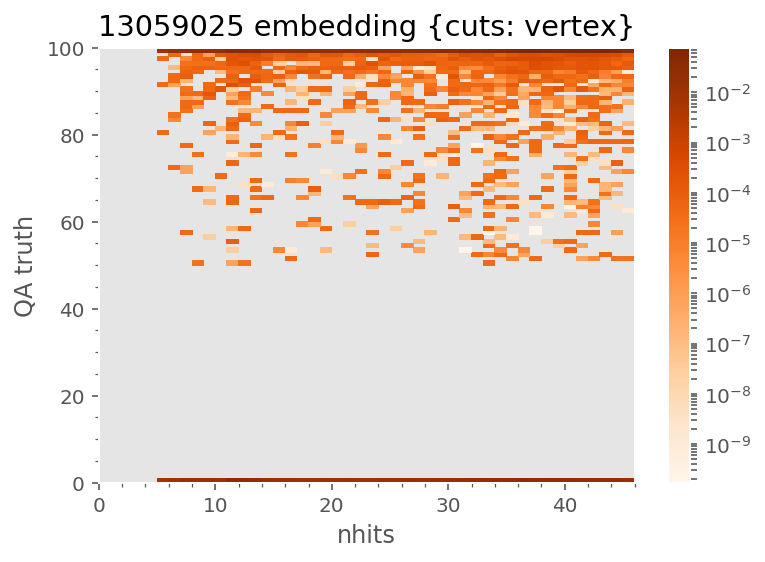

In [21]:
for xds in datasets:
    locals().update(xds.__dict__)

    if not is_embed: continue

    plot_histo2d(
        nhits, qa_truth,
        bins=(range(TPC_NUM_ROWS+2), 100),
        weights=w,
        cut=vertex_cut,
        norm=LogNorm(),
        )
    plt.xlabel(r"nhits")
    plt.ylabel(r"QA truth")
    plt.title("{} {{cuts: vertex}}".format(title))
    plt.minorticks_on()
    plt.show()

    locals().update(xds.erase_dict)

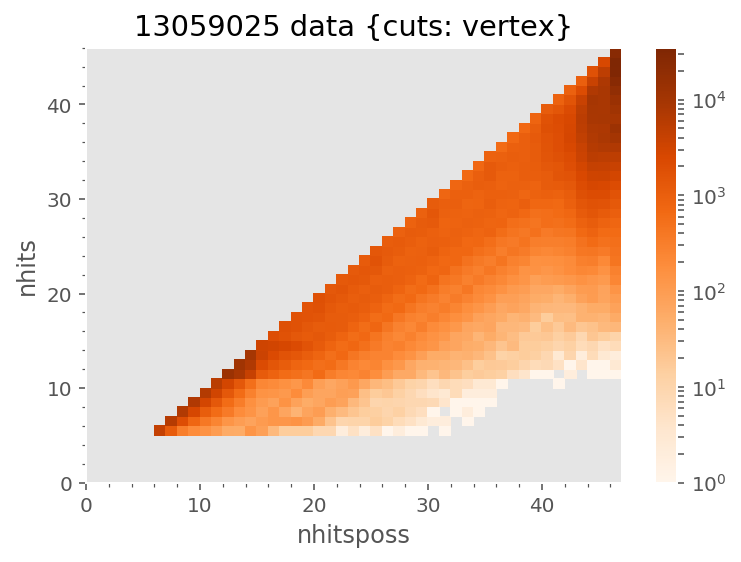

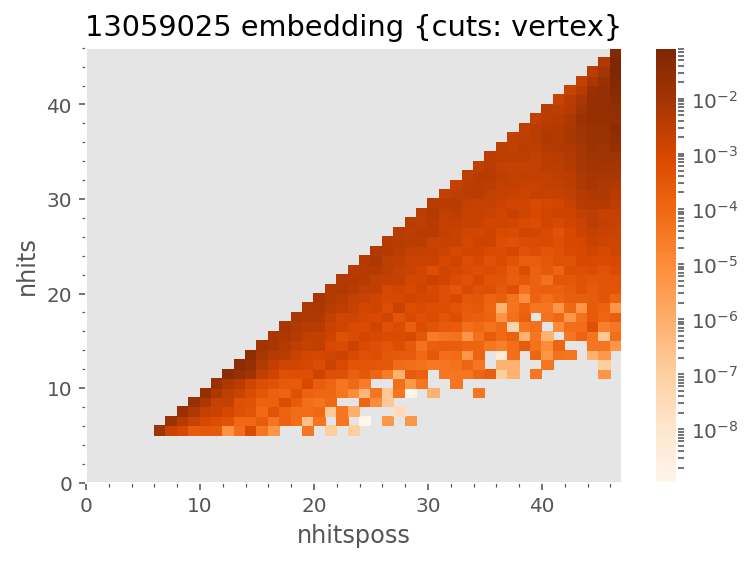

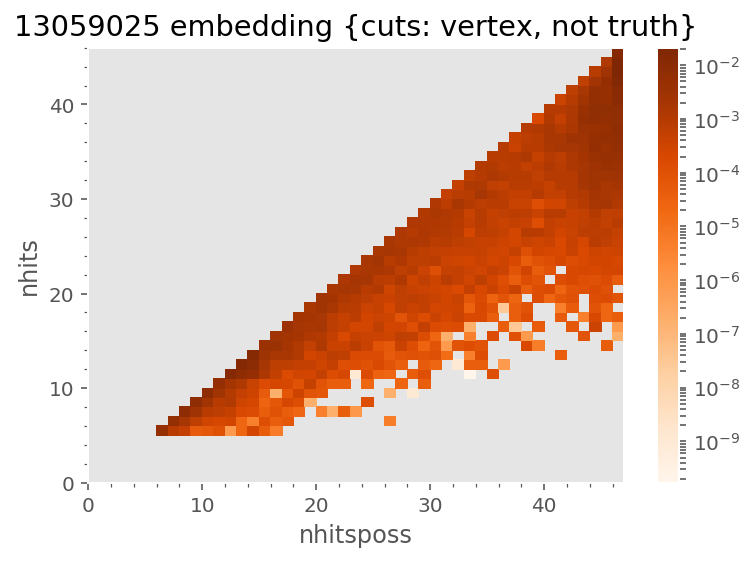

In [22]:
for xds in datasets:
    locals().update(xds.__dict__)

    plot_histo2d(
        nph, nhits,
        bins=(range(TPC_NUM_ROWS+3), range(TPC_NUM_ROWS+2)),
        weights=w,
        cut=vertex_cut,
        norm=LogNorm(),
        )
    plt.xlabel(r"nhitsposs")
    plt.ylabel(r"nhits")
    plt.title("{} {{cuts: vertex}}".format(title))
    plt.minorticks_on()
    plt.show()

    if is_embed:
        plot_histo2d(
            nph, nhits,
            bins=(range(TPC_NUM_ROWS+3), range(TPC_NUM_ROWS+2)),
            weights=w,
            cut=and_cuts(vertex_cut, id_truth==0),
            norm=LogNorm(),
            )
        plt.xlabel(r"nhitsposs")
        plt.ylabel(r"nhits")
        plt.title("{} {{cuts: vertex, not truth}}".format(title))
        plt.minorticks_on()
        plt.show()

    locals().update(xds.erase_dict)

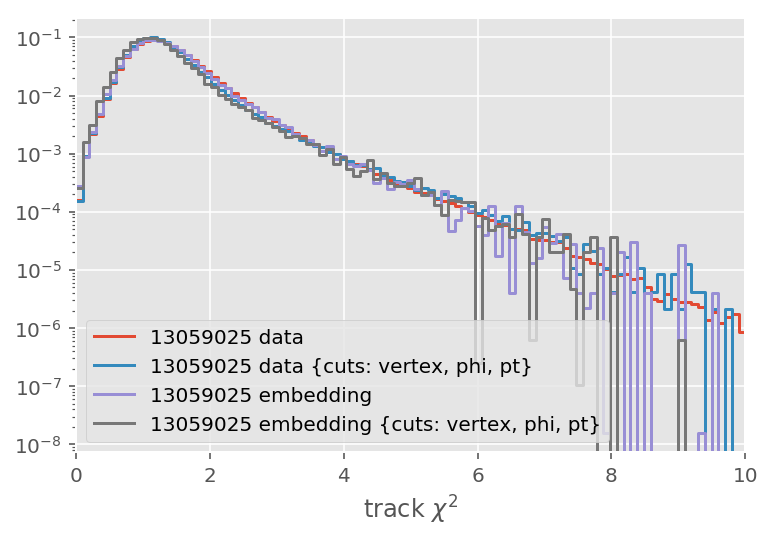

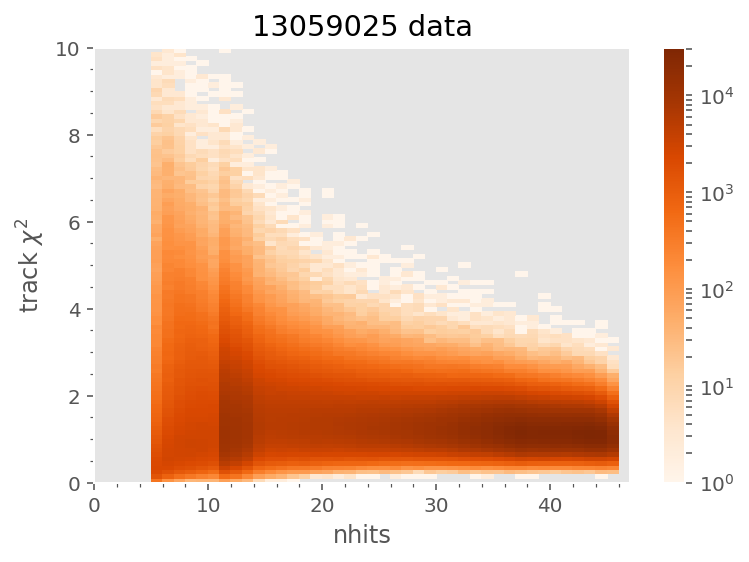

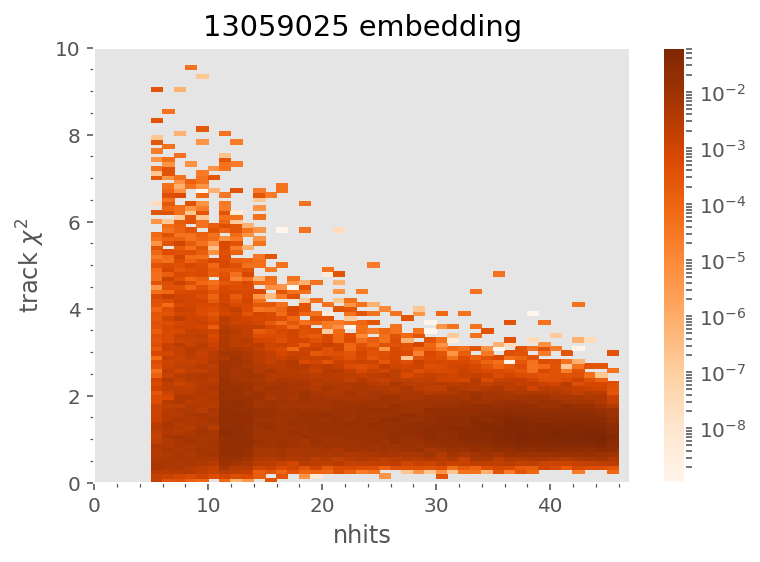

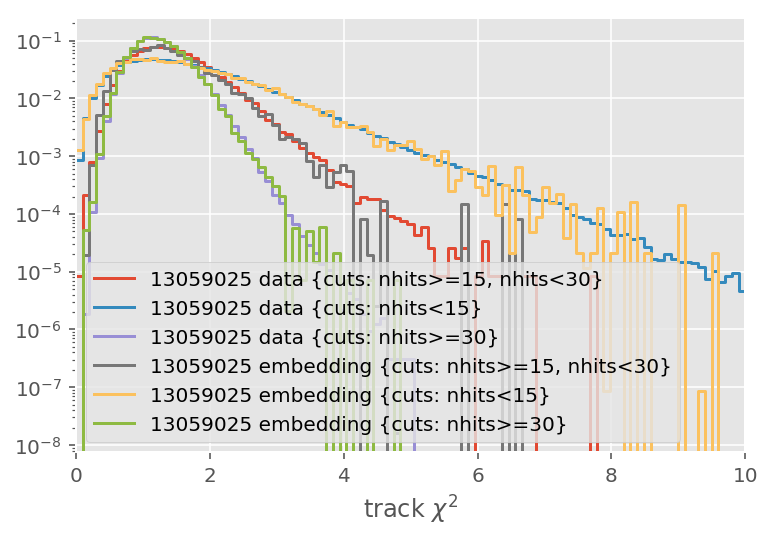

In [23]:
bins = np.linspace(0., 10., 100)

for xds in datasets:
    locals().update(xds.__dict__)

    (_, bins) = plot_histo1d(
        chi2,
        bins=bins,
        weights=w,
        normalize=True,
        label=title,
        )
    (_, bins) = plot_histo1d(
        chi2,
        bins=bins,
        weights=w,
        cut=and_cuts(vertex_cut, phi_cut, pt>0.2),
        normalize=True,
        label=title + " {cuts: vertex, phi, pt}",
        )

    locals().update(xds.erase_dict)
    
plt.yscale('log')
plt.xlabel(r"track $\chi^2$")
plt.legend()
plt.show()

for xds in datasets:
    locals().update(xds.__dict__)

    plot_histo2d(
        nhits, chi2,
        bins=(range(TPC_NUM_ROWS+3), np.linspace(0., 10., 100)),
        weights=w,
        norm=LogNorm(),
        )
    plt.xlabel(r"nhits")
    plt.ylabel(r"track $\chi^2$")
    plt.title(title)
    plt.minorticks_on()
    plt.show()

    locals().update(xds.erase_dict)

for xds in datasets:
    locals().update(xds.__dict__)

    (_, bins) = plot_histo1d(
        chi2,
        bins=bins,
        weights=w,
        cut=and_cuts(vertex_cut, phi_cut, nhits>=15, nhits<30),
        normalize=True,
        label=title + " {cuts: nhits>=15, nhits<30}",
        )
    (_, bins) = plot_histo1d(
        chi2,
        bins=bins,
        weights=w,
        cut=and_cuts(nhits<15),
        normalize=True,
        label=title + " {cuts: nhits<15}",
        )
    (_, bins) = plot_histo1d(
        chi2,
        bins=bins,
        weights=w,
        cut=and_cuts(nhits>=30),
        normalize=True,
        label=title + " {cuts: nhits>=30}",
        )

    locals().update(xds.erase_dict)

plt.yscale('log')
plt.xlabel(r"track $\chi^2$")
plt.legend()
plt.show()

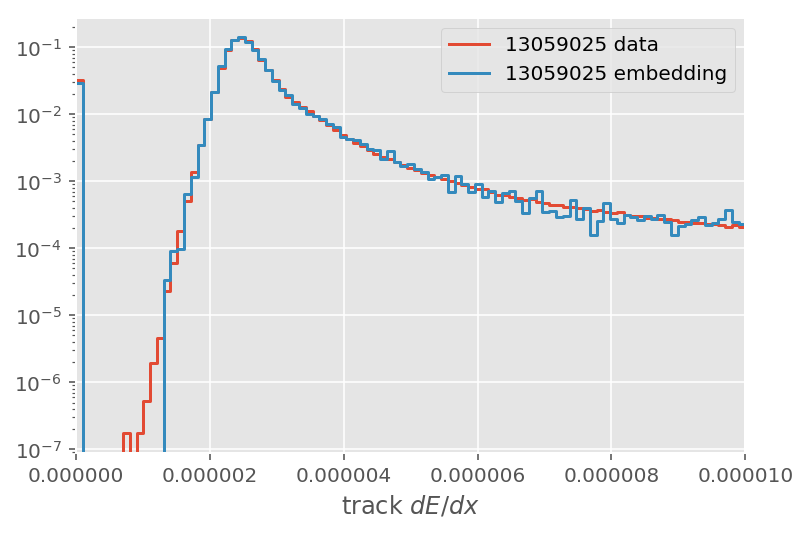

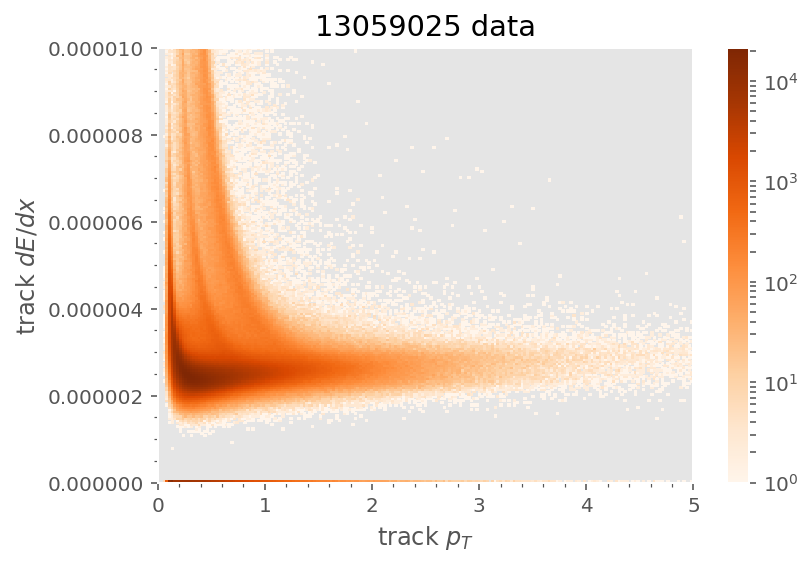

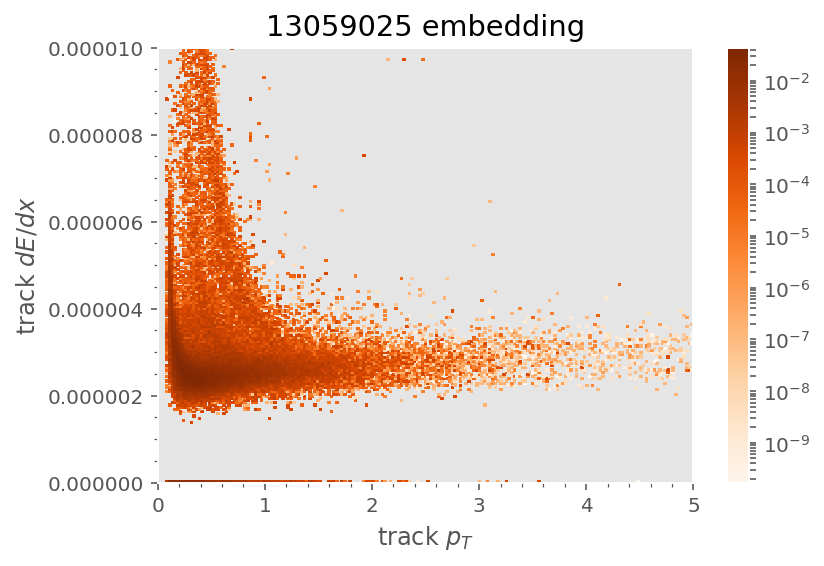

In [24]:
bins = np.linspace(0., 1e-5, 100)

for xds in datasets:
    locals().update(xds.__dict__)

    (_, bins) = plot_histo1d(
        dEdx,
        bins=bins,
        weights=w,
        normalize=True,
        label=title,
        )

    locals().update(xds.erase_dict)
    
plt.yscale('log')
plt.xlabel(r"track $dE/dx$")
plt.legend()
plt.show()

for xds in datasets:
    locals().update(xds.__dict__)

    plot_histo2d(
        pt, dEdx,
        bins=(np.linspace(0., 5., 200), np.linspace(0., 1e-5, 200)),
        weights=w,
        norm=LogNorm(),
        )
    plt.xlabel(r"track $p_T$")
    plt.ylabel(r"track $dE/dx$")
    plt.title(title)
    plt.minorticks_on()
    plt.show()

    locals().update(xds.erase_dict)